In [1]:
# Train on RAF-DB
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
torch.cuda.empty_cache()


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3070


In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

from approach.ResEmoteNet import ResEmoteNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Transform the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Load the model
model = ResEmoteNet()
model.to('cuda')
# Print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

Using cuda device
80,238,599 total parameters.


In [3]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RafDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image names and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.labels = pd.read_csv(csv_file, header=None, names=["image", "label"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
        
        # Get image path and label
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.labels.iloc[idx, 1]) - 1  # Adjust label to start from 0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


def load_data(base_dir, batch_size=16, transform=None):
    """
    Function to load train and test datasets and return their DataLoaders.

    Args:
        base_dir (str): Base directory containing 'raf-db' folder.
        batch_size (int): Batch size for the DataLoader.
        transform (callable, optional): Transformations to apply to the images.

    Returns:
        tuple: Train DataLoader, Test DataLoader
    """
    # Paths to CSV and image directories
    train_csv = os.path.join(base_dir, "raf-db", "train_labels.csv")
    test_csv = os.path.join(base_dir, "raf-db", "test_labels.csv")
    train_img_dir = os.path.join(base_dir, "raf-db", "DATASET", "train")
    test_img_dir = os.path.join(base_dir, "raf-db", "DATASET", "test")
    
    # Datasets
    train_dataset = RafDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = RafDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


base_dir = "/workspace/"
train_loader, test_loader = load_data(base_dir=base_dir, batch_size=16, transform=transform)

# Inspect a batch
train_images, train_labels = next(iter(train_loader))
print(f"Train batch: Images shape {train_images.shape}, Labels shape {train_labels.shape}")

Train batch: Images shape torch.Size([16, 3, 64, 64]), Labels shape torch.Size([16])


In [4]:
# Hyperparameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [7]:
# Start training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    # with torch.no_grad():
    #     for data in val_loader:
    #         inputs, labels = data[0].to(device), data[1].to(device)
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    #         val_running_loss += loss.item()
    #         _, predicted = torch.max(outputs.data, 1)
    #         val_total += labels.size(0)
    #         val_correct += (predicted == labels).sum().item()

    # val_loss = val_running_loss / len(val_loader)
    # val_acc = val_correct / val_total
    # val_losses.append(val_loss)
    # val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}")
    epoch_counter += 1
    
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     patience_counter = 0 
    #     torch.save(model.state_dict(), 'best_model.pth')
    # else:
    #     patience_counter += 1
    #     print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    # if patience_counter > patience:
    #     print("Stopping early due to lack of improvement in validation accuracy.")
    #     break

Epoch 1/80: 100% 767/767 [00:30<00:00, 24.76it/s]


Epoch 1, Train Loss: 1.087017729159595, Train Accuracy: 0.6216282291581778, Test Loss: 0.8845142349988843, Test Accuracy: 0.6945893089960886


Epoch 2/80: 100% 767/767 [00:30<00:00, 24.81it/s]


Epoch 2, Train Loss: 0.9644269292015762, Train Accuracy: 0.6658789014750224, Test Loss: 0.8256875798106194, Test Accuracy: 0.7115384615384616


Epoch 3/80: 100% 767/767 [00:30<00:00, 24.77it/s]


Epoch 3, Train Loss: 0.8910887183468531, Train Accuracy: 0.6921196316518621, Test Loss: 0.7889967036511129, Test Accuracy: 0.7209908735332464


Epoch 4/80: 100% 767/767 [00:30<00:00, 24.75it/s]


Epoch 4, Train Loss: 0.8169157281226564, Train Accuracy: 0.7188493195338603, Test Loss: 0.7316137193508135, Test Accuracy: 0.7516297262059974


Epoch 5/80: 100% 767/767 [00:31<00:00, 24.44it/s]


Epoch 5, Train Loss: 0.763277100149003, Train Accuracy: 0.7392225572487979, Test Loss: 0.6947034677432384, Test Accuracy: 0.7594524119947849


Epoch 6/80: 100% 767/767 [00:33<00:00, 22.97it/s]


Epoch 6, Train Loss: 0.7058397647687944, Train Accuracy: 0.7577214570939613, Test Loss: 0.6905048097250983, Test Accuracy: 0.7526075619295959


Epoch 7/80: 100% 767/767 [00:33<00:00, 22.63it/s]


Epoch 7, Train Loss: 0.6647503855874983, Train Accuracy: 0.7714122728383995, Test Loss: 0.7188468074503666, Test Accuracy: 0.7477183833116037


Epoch 8/80: 100% 767/767 [00:32<00:00, 23.52it/s]


Epoch 8, Train Loss: 0.6176155658518941, Train Accuracy: 0.7847771167793985, Test Loss: 0.657769010392561, Test Accuracy: 0.7711864406779662


Epoch 9/80: 100% 767/767 [00:32<00:00, 23.56it/s]


Epoch 9, Train Loss: 0.5697051999116659, Train Accuracy: 0.8006682421970499, Test Loss: 0.6817085669220736, Test Accuracy: 0.7767275097783573


Epoch 10/80: 100% 767/767 [00:32<00:00, 23.49it/s]


Epoch 10, Train Loss: 0.5378556158757893, Train Accuracy: 0.8133811425311711, Test Loss: 0.7465469805174507, Test Accuracy: 0.7457627118644068


Epoch 11/80: 100% 767/767 [00:32<00:00, 23.43it/s]


Epoch 11, Train Loss: 0.494717976153674, Train Accuracy: 0.8316355635237552, Test Loss: 0.645142793529279, Test Accuracy: 0.7858539765319427


Epoch 12/80: 100% 767/767 [00:31<00:00, 24.58it/s]


Epoch 12, Train Loss: 0.4576829090287042, Train Accuracy: 0.8449189145138946, Test Loss: 0.6587181363235383, Test Accuracy: 0.7829204693611473


Epoch 13/80: 100% 767/767 [00:31<00:00, 24.73it/s]


Epoch 13, Train Loss: 0.43568622595308815, Train Accuracy: 0.8521717871404123, Test Loss: 0.7120803422876634, Test Accuracy: 0.7721642764015645


Epoch 14/80: 100% 767/767 [00:31<00:00, 24.74it/s]


Epoch 14, Train Loss: 0.39564940953600514, Train Accuracy: 0.8672479830494663, Test Loss: 0.6660508453011668, Test Accuracy: 0.7858539765319427


Epoch 15/80: 100% 767/767 [00:31<00:00, 24.65it/s]


Epoch 15, Train Loss: 0.36693287498986704, Train Accuracy: 0.8769456442017766, Test Loss: 0.6821997976779434, Test Accuracy: 0.7871577574967406


Epoch 16/80: 100% 767/767 [00:31<00:00, 24.70it/s]


Epoch 16, Train Loss: 0.3392793057289708, Train Accuracy: 0.8875397278135442, Test Loss: 0.7241238265366216, Test Accuracy: 0.7825945241199479


Epoch 17/80: 100% 767/767 [00:31<00:00, 24.71it/s]


Epoch 17, Train Loss: 0.31763863632263617, Train Accuracy: 0.8961779806046777, Test Loss: 0.7960295659237696, Test Accuracy: 0.7597783572359843


Epoch 18/80: 100% 767/767 [00:31<00:00, 24.70it/s]


Epoch 18, Train Loss: 0.28470875758973996, Train Accuracy: 0.9044902615923722, Test Loss: 0.6926093655686903, Test Accuracy: 0.7966101694915254


Epoch 19/80: 100% 767/767 [00:31<00:00, 24.72it/s]


Epoch 19, Train Loss: 0.2761262524958015, Train Accuracy: 0.9070165430690246, Test Loss: 0.7476989618153311, Test Accuracy: 0.7702086049543677


Epoch 20/80: 100% 767/767 [00:31<00:00, 24.63it/s]


Epoch 20, Train Loss: 0.2553282977559032, Train Accuracy: 0.9151658381549996, Test Loss: 0.7219057844001023, Test Accuracy: 0.7959582790091264


Epoch 21/80: 100% 767/767 [00:32<00:00, 23.28it/s]


Epoch 21, Train Loss: 0.2290722213738939, Train Accuracy: 0.9260044006193464, Test Loss: 0.7559587825586883, Test Accuracy: 0.7884615384615384


Epoch 22/80: 100% 767/767 [00:32<00:00, 23.33it/s]


Epoch 22, Train Loss: 0.2189541989973852, Train Accuracy: 0.9295085975063158, Test Loss: 0.7383140287226221, Test Accuracy: 0.7770534550195567


Epoch 23/80: 100% 767/767 [00:32<00:00, 23.31it/s]


Epoch 23, Train Loss: 0.20093750643314406, Train Accuracy: 0.9344796675087605, Test Loss: 0.7169132056515082, Test Accuracy: 0.8054106910039114


Epoch 24/80: 100% 767/767 [00:32<00:00, 23.31it/s]


Epoch 24, Train Loss: 0.18901704446712542, Train Accuracy: 0.9387173009534675, Test Loss: 0.7868366941820568, Test Accuracy: 0.7848761408083442


Epoch 25/80: 100% 767/767 [00:32<00:00, 23.26it/s]


Epoch 25, Train Loss: 0.1761842881119294, Train Accuracy: 0.9444218075136501, Test Loss: 0.8422754544493122, Test Accuracy: 0.7855280312907431


Epoch 26/80: 100% 767/767 [00:31<00:00, 24.07it/s]


Epoch 26, Train Loss: 0.16465704441871956, Train Accuracy: 0.9466221171868633, Test Loss: 0.8153696914926817, Test Accuracy: 0.7861799217731421


Epoch 27/80: 100% 767/767 [00:30<00:00, 24.94it/s]


Epoch 27, Train Loss: 0.1524734606364113, Train Accuracy: 0.9502892999755521, Test Loss: 0.7939507935943766, Test Accuracy: 0.7949804432855281


Epoch 28/80: 100% 767/767 [00:30<00:00, 24.95it/s]


Epoch 28, Train Loss: 0.13505653881667015, Train Accuracy: 0.9554233558797164, Test Loss: 0.8563494616449437, Test Accuracy: 0.7969361147327249


Epoch 29/80: 100% 767/767 [00:30<00:00, 24.95it/s]


Epoch 29, Train Loss: 0.13902405463523357, Train Accuracy: 0.9564012712900334, Test Loss: 0.8309014913371963, Test Accuracy: 0.7871577574967406


Epoch 30/80: 100% 767/767 [00:30<00:00, 24.93it/s]


Epoch 30, Train Loss: 0.1239381034465718, Train Accuracy: 0.959498003422704, Test Loss: 0.8763097617823709, Test Accuracy: 0.7858539765319427


Epoch 31/80: 100% 767/767 [00:32<00:00, 23.90it/s]


Epoch 31, Train Loss: 0.11615370263545434, Train Accuracy: 0.9627577214570939, Test Loss: 0.9101354529866512, Test Accuracy: 0.7855280312907431


Epoch 32/80: 100% 767/767 [00:33<00:00, 22.62it/s]


Epoch 32, Train Loss: 0.1066691277718968, Train Accuracy: 0.9656099747371852, Test Loss: 0.9134086320227652, Test Accuracy: 0.788787483702738


Epoch 33/80: 100% 767/767 [00:33<00:00, 22.81it/s]


Epoch 33, Train Loss: 0.10964253525379583, Train Accuracy: 0.9647135522777279, Test Loss: 0.886325113716642, Test Accuracy: 0.7891134289439374


Epoch 34/80: 100% 767/767 [00:33<00:00, 22.62it/s]


Epoch 34, Train Loss: 0.10525298314190298, Train Accuracy: 0.9647950452285877, Test Loss: 0.8683552750671879, Test Accuracy: 0.7926988265971316


Epoch 35/80: 100% 767/767 [00:33<00:00, 22.59it/s]


Epoch 35, Train Loss: 0.0955632022159894, Train Accuracy: 0.9713959742482275, Test Loss: 0.8599060191712246, Test Accuracy: 0.7904172099087353


Epoch 36/80: 100% 767/767 [00:33<00:00, 22.65it/s]


Epoch 36, Train Loss: 0.08414951048447171, Train Accuracy: 0.9730258332654226, Test Loss: 0.904272938575256, Test Accuracy: 0.7972620599739244


Epoch 37/80: 100% 767/767 [00:32<00:00, 23.63it/s]


Epoch 37, Train Loss: 0.08600364105918322, Train Accuracy: 0.9726998614619835, Test Loss: 0.8957467488896024, Test Accuracy: 0.795632333767927


Epoch 38/80: 100% 767/767 [00:31<00:00, 24.41it/s]


Epoch 38, Train Loss: 0.0772203363023906, Train Accuracy: 0.975470621791215, Test Loss: 0.9936702266271217, Test Accuracy: 0.780638852672751


Epoch 39/80: 100% 767/767 [00:32<00:00, 23.67it/s]


Epoch 39, Train Loss: 0.06908622650236694, Train Accuracy: 0.9782413821204465, Test Loss: 0.9587291650924877, Test Accuracy: 0.803129074315515


Epoch 40/80: 100% 767/767 [00:33<00:00, 23.16it/s]


Epoch 40, Train Loss: 0.07120905007282606, Train Accuracy: 0.9774264526118491, Test Loss: 0.9031227686418409, Test Accuracy: 0.7852020860495437


Epoch 41/80: 100% 767/767 [00:33<00:00, 23.13it/s]


Epoch 41, Train Loss: 0.06824001957423502, Train Accuracy: 0.9786488468747453, Test Loss: 1.0276119178197405, Test Accuracy: 0.780638852672751


Epoch 42/80: 100% 767/767 [00:33<00:00, 22.82it/s]


Epoch 42, Train Loss: 0.0674739944152616, Train Accuracy: 0.9788118327764649, Test Loss: 0.9789270991439025, Test Accuracy: 0.7985658409387223


Epoch 43/80: 100% 767/767 [00:33<00:00, 23.16it/s]


Epoch 43, Train Loss: 0.06691802532654656, Train Accuracy: 0.9786488468747453, Test Loss: 0.9480967544071367, Test Accuracy: 0.7966101694915254


Epoch 44/80: 100% 767/767 [00:31<00:00, 24.00it/s]


Epoch 44, Train Loss: 0.054177145609369405, Train Accuracy: 0.9829679732703122, Test Loss: 1.0121230687761151, Test Accuracy: 0.7936766623207301


Epoch 45/80: 100% 767/767 [00:30<00:00, 24.87it/s]


Epoch 45, Train Loss: 0.0616865869066763, Train Accuracy: 0.9807676635970989, Test Loss: 1.0360480471078215, Test Accuracy: 0.7894393741851369


Epoch 46/80: 100% 767/767 [00:31<00:00, 24.01it/s]


Epoch 46, Train Loss: 0.058680219426297316, Train Accuracy: 0.9808491565479586, Test Loss: 0.9870624754166784, Test Accuracy: 0.7904172099087353


Epoch 47/80: 100% 767/767 [00:31<00:00, 24.51it/s]


Epoch 47, Train Loss: 0.057931311107228475, Train Accuracy: 0.9815825931056964, Test Loss: 0.9717974185364255, Test Accuracy: 0.788787483702738


Epoch 48/80: 100% 767/767 [00:32<00:00, 23.92it/s]


Epoch 48, Train Loss: 0.06229667660632341, Train Accuracy: 0.9801972129410806, Test Loss: 0.8626977785110436, Test Accuracy: 0.7992177314211213


Epoch 49/80: 100% 767/767 [00:31<00:00, 24.64it/s]


Epoch 49, Train Loss: 0.04544247401929046, Train Accuracy: 0.9850867899926656, Test Loss: 0.9894099011013395, Test Accuracy: 0.7995436766623207


Epoch 50/80: 100% 767/767 [00:30<00:00, 24.81it/s]


Epoch 50, Train Loss: 0.05051403948693412, Train Accuracy: 0.9837014098280499, Test Loss: 0.9983157343382724, Test Accuracy: 0.7972620599739244


Epoch 51/80: 100% 767/767 [00:32<00:00, 23.92it/s]


Epoch 51, Train Loss: 0.04679383091724021, Train Accuracy: 0.9839458886806292, Test Loss: 0.949778742074462, Test Accuracy: 0.7985658409387223


Epoch 52/80: 100% 767/767 [00:32<00:00, 23.89it/s]


Epoch 52, Train Loss: 0.04834326248396051, Train Accuracy: 0.9840273816314888, Test Loss: 0.9758530986082405, Test Accuracy: 0.8044328552803129


Epoch 53/80: 100% 767/767 [00:34<00:00, 22.00it/s]


Epoch 53, Train Loss: 0.041669683007996894, Train Accuracy: 0.9861461983538424, Test Loss: 0.9792876931320885, Test Accuracy: 0.8014993481095176


Epoch 54/80: 100% 767/767 [00:35<00:00, 21.33it/s]


Epoch 54, Train Loss: 0.043251605654562264, Train Accuracy: 0.9859017195012632, Test Loss: 0.9935148221211421, Test Accuracy: 0.7917209908735332


Epoch 55/80: 100% 767/767 [00:35<00:00, 21.38it/s]


Epoch 55, Train Loss: 0.03395407481774802, Train Accuracy: 0.9894059163882324, Test Loss: 1.005922789073414, Test Accuracy: 0.8011734028683182


Epoch 56/80: 100% 767/767 [00:35<00:00, 21.45it/s]


Epoch 56, Train Loss: 0.04073681576947895, Train Accuracy: 0.9882650150761959, Test Loss: 1.0371142223060208, Test Accuracy: 0.7913950456323338


Epoch 57/80: 100% 767/767 [00:35<00:00, 21.39it/s]


Epoch 57, Train Loss: 0.034161889487286684, Train Accuracy: 0.9887539727813545, Test Loss: 1.0205224452899226, Test Accuracy: 0.8070404172099087


Epoch 58/80: 100% 767/767 [00:35<00:00, 21.40it/s]


Epoch 58, Train Loss: 0.0395628360278674, Train Accuracy: 0.9871241137641594, Test Loss: 1.0565403415894252, Test Accuracy: 0.7953063885267275


Epoch 59/80: 100% 767/767 [00:34<00:00, 22.28it/s]


Epoch 59, Train Loss: 0.04379915476183693, Train Accuracy: 0.9861461983538424, Test Loss: 0.9911095760453463, Test Accuracy: 0.7949804432855281


Epoch 60/80: 100% 767/767 [00:31<00:00, 24.27it/s]


Epoch 60, Train Loss: 0.03845473529853387, Train Accuracy: 0.9876130714693179, Test Loss: 1.0288055681404178, Test Accuracy: 0.7953063885267275


Epoch 61/80: 100% 767/767 [00:32<00:00, 23.74it/s]


Epoch 61, Train Loss: 0.0374227065525538, Train Accuracy: 0.9884280009779154, Test Loss: 1.0838141246241928, Test Accuracy: 0.7900912646675359


Epoch 62/80: 100% 767/767 [00:32<00:00, 23.82it/s]


Epoch 62, Train Loss: 0.02829188578228702, Train Accuracy: 0.9919321978648847, Test Loss: 1.023867860100798, Test Accuracy: 0.8148631029986962


Epoch 63/80: 100% 767/767 [00:32<00:00, 23.59it/s]


Epoch 63, Train Loss: 0.031779714635083986, Train Accuracy: 0.9893244234373727, Test Loss: 1.0437367008688245, Test Accuracy: 0.7959582790091264


Epoch 64/80: 100% 767/767 [00:32<00:00, 23.62it/s]


Epoch 64, Train Loss: 0.036618764357368286, Train Accuracy: 0.9889169586830739, Test Loss: 1.0153110467846318, Test Accuracy: 0.7969361147327249


Epoch 65/80: 100% 767/767 [00:30<00:00, 24.76it/s]


Epoch 65, Train Loss: 0.032852080038294595, Train Accuracy: 0.9890799445847934, Test Loss: 1.0615328734770249, Test Accuracy: 0.8060625814863103


Epoch 66/80: 100% 767/767 [00:30<00:00, 25.02it/s]


Epoch 66, Train Loss: 0.02770189549018541, Train Accuracy: 0.9910357754054274, Test Loss: 1.04436518932395, Test Accuracy: 0.8005215123859192


Epoch 67/80: 100% 767/767 [00:30<00:00, 24.99it/s]


Epoch 67, Train Loss: 0.028402388277107216, Train Accuracy: 0.9907098036019885, Test Loss: 1.083087399082918, Test Accuracy: 0.8014993481095176


Epoch 68/80: 100% 767/767 [00:30<00:00, 25.00it/s]


Epoch 68, Train Loss: 0.031755112795276055, Train Accuracy: 0.9910357754054274, Test Loss: 1.0379700888467294, Test Accuracy: 0.7936766623207301


Epoch 69/80: 100% 767/767 [00:30<00:00, 25.01it/s]


Epoch 69, Train Loss: 0.027828676050441307, Train Accuracy: 0.9925841414717627, Test Loss: 1.088860817291182, Test Accuracy: 0.7992177314211213


Epoch 70/80: 100% 767/767 [00:30<00:00, 25.01it/s]


Epoch 70, Train Loss: 0.024917122291714187, Train Accuracy: 0.9910357754054274, Test Loss: 1.1279119011396688, Test Accuracy: 0.7975880052151239


Epoch 71/80: 100% 767/767 [00:30<00:00, 25.01it/s]


Epoch 71, Train Loss: 0.030130643031786777, Train Accuracy: 0.9907912965528481, Test Loss: 1.041286781564698, Test Accuracy: 0.8001955671447197


Epoch 72/80: 100% 767/767 [00:30<00:00, 24.99it/s]


Epoch 72, Train Loss: 0.027178240566441636, Train Accuracy: 0.9906283106511287, Test Loss: 1.0167476639956778, Test Accuracy: 0.8014993481095176


Epoch 73/80: 100% 767/767 [00:30<00:00, 25.02it/s]


Epoch 73, Train Loss: 0.02417233880290384, Train Accuracy: 0.9932360850786407, Test Loss: 1.1232198780949147, Test Accuracy: 0.7943285528031291


Epoch 74/80: 100% 767/767 [00:30<00:00, 24.99it/s]


Epoch 74, Train Loss: 0.03432481446825987, Train Accuracy: 0.9896503952408117, Test Loss: 1.048107143381344, Test Accuracy: 0.795632333767927


Epoch 75/80: 100% 767/767 [00:30<00:00, 24.79it/s]


Epoch 75, Train Loss: 0.025184147016291347, Train Accuracy: 0.9928286203243419, Test Loss: 1.0408441534776405, Test Accuracy: 0.8008474576271186


Epoch 76/80: 100% 767/767 [00:31<00:00, 24.38it/s]


Epoch 76, Train Loss: 0.024287500906581754, Train Accuracy: 0.9923396626191835, Test Loss: 1.1721985216260389, Test Accuracy: 0.7936766623207301


Epoch 77/80: 100% 767/767 [00:32<00:00, 23.81it/s]


Epoch 77, Train Loss: 0.02796932335386112, Train Accuracy: 0.9919321978648847, Test Loss: 1.0749489425104268, Test Accuracy: 0.7998696219035202


Epoch 78/80: 100% 767/767 [00:32<00:00, 23.58it/s]


Epoch 78, Train Loss: 0.023837956528727673, Train Accuracy: 0.9931545921277809, Test Loss: 1.1597100146291648, Test Accuracy: 0.7858539765319427


Epoch 79/80: 100% 767/767 [00:31<00:00, 23.99it/s]


Epoch 79, Train Loss: 0.024409176410258616, Train Accuracy: 0.9929101132752017, Test Loss: 1.0414478769818818, Test Accuracy: 0.7995436766623207


Epoch 80/80: 100% 767/767 [00:32<00:00, 23.83it/s]


Epoch 80, Train Loss: 0.025202310481087856, Train Accuracy: 0.9922581696683237, Test Loss: 1.008240808915313, Test Accuracy: 0.8001955671447197


In [16]:
# Truncate the lists to match the number of epochs
train_losses = train_losses[:epoch_counter]
test_losses = test_losses[:epoch_counter]
train_accuracies = train_accuracies[:epoch_counter]
test_accuracies = test_accuracies[:epoch_counter]

# Create the DataFrame
df = pd.DataFrame({
    'Epoch': range(1, epoch_counter + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
})

# Save the DataFrame to a CSV file
df.to_csv('result_four4all.csv', index=False)
print("Results saved to 'result_four4all.csv'.")

Results saved to 'result_four4all.csv'.


In [15]:
print(f"Epochs: {epoch_counter}")
print(f"Train Losses: {len(train_losses)}")
print(f"Test Losses: {len(test_losses)}")
print(f"Train Accuracies: {len(train_accuracies)}")
print(f"Test Accuracies: {len(test_accuracies)}")


Epochs: 81
Train Losses: 82
Test Losses: 82
Train Accuracies: 82
Test Accuracies: 82


In [10]:
import h5py

def save_model_as_h5(model, file_path):
    """
    Save a PyTorch model as an H5 file.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        file_path (str): Path to save the .h5 file.
    """
    # Convert the model's state_dict to a dictionary of NumPy arrays
    model_weights = {k: v.cpu().numpy() for k, v in model.state_dict().items()}

    with h5py.File(file_path, 'w') as h5_file:
        for key, value in model_weights.items():
            h5_file.create_dataset(key, data=value)
save_model_as_h5(model, "model.h5")
print("Model saved as model.h5")

Model saved as model.h5


In [13]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 107.5 MB/s eta 0:00:00a 0:00:01


Confusion Matrix:
 [[ 244   14    6   13   15    8   29]
 [  12   41    1    4   10    3    3]
 [   6    2   76   16   19   14   27]
 [  10    0   20 1062   26    8   59]
 [   7    2   20   27  361    5   56]
 [   3    5   11   11    3  120    9]
 [  11    1   28   35   56    4  545]]


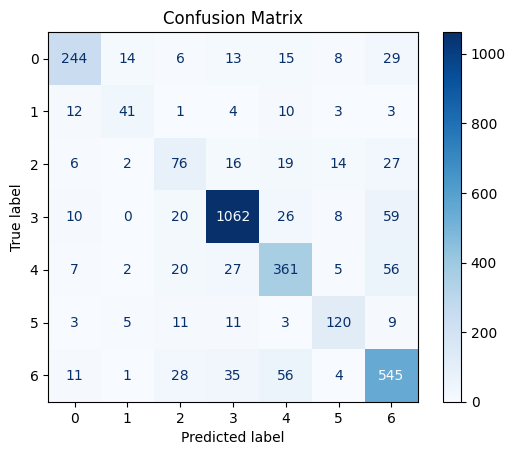

In [14]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Confusion Matrix (Counts):
 [[ 245   14    5   10   14    8   33]
 [  10   43    3    4    6    3    5]
 [   4    3   82   14   17   11   29]
 [  12    1   19 1064   26    5   58]
 [   8    2   16   27  365    7   53]
 [   7    2   11    9    2  121   10]
 [  15    1   24   31   55    4  550]]
Confusion Matrix (Percentages):
 [[7.44680851e-01 4.25531915e-02 1.51975684e-02 3.03951368e-02
  4.25531915e-02 2.43161094e-02 1.00303951e-01]
 [1.35135135e-01 5.81081081e-01 4.05405405e-02 5.40540541e-02
  8.10810811e-02 4.05405405e-02 6.75675676e-02]
 [2.50000000e-02 1.87500000e-02 5.12500000e-01 8.75000000e-02
  1.06250000e-01 6.87500000e-02 1.81250000e-01]
 [1.01265823e-02 8.43881857e-04 1.60337553e-02 8.97890295e-01
  2.19409283e-02 4.21940928e-03 4.89451477e-02]
 [1.67364017e-02 4.18410042e-03 3.34728033e-02 5.64853556e-02
  7.63598326e-01 1.46443515e-02 1.10878661e-01]
 [4.32098765e-02 1.23456790e-02 6.79012346e-02 5.55555556e-02
  1.23456790e-02 7.46913580e-01 6.17283951e-02]
 [2.20588235

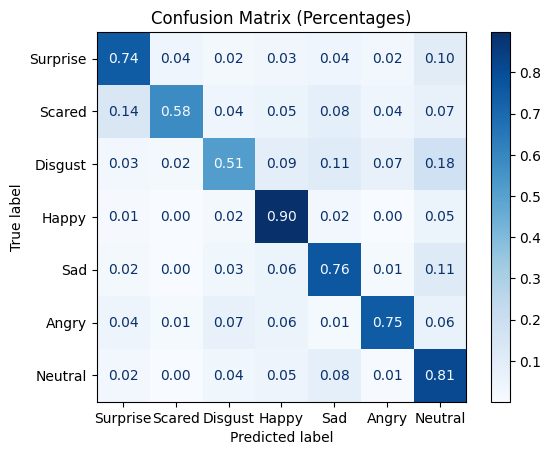

In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define label names
label_names = [
    "Surprise", "Scared", "Disgust", "Happy", "Sad", "Angry", "Neutral"
]

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Counts):\n", conf_matrix)

# Normalize confusion matrix by row (true classes) to get percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
print("Confusion Matrix (Percentages):\n", conf_matrix_normalized)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # Display percentages with 2 decimal places
plt.title("Confusion Matrix (Percentages)")
plt.show()
